In [1]:
import gc
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
from helperfunctions import *

In [2]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.text import Text

In [3]:
# Modify input parameters to correspond with desired simulation
E1h = 7
dE12 = 0.4
dE13 = 0.8
p2 = 0.15
p3 = 0.05
masking = 0
C0 = 0.008
w1 = 0
w2 = 0.5
q12 = 0
q13 = 0
q23 = 0
memToGCFrac=0
outputprob=0.05
outputpcfrac=0.1
rho=[[0.95, 0.4], [0.4, 0.95]]
earlybooster=0

def get_results(vaxnum, tmax):
    all_results = []
    for i in range(0, 10):
        first = i*200+1
        last = first+199
        param=initializeParameters(vaxnum,
                 E1h,
                 dE12,
                 dE13,
                 p2,
                 p3,
                 masking,
                 C0,
                 w1,
                 w2,
                 q12,
                 q13,
                 q23,
                 memToGCFrac,
                 outputprob,
                 outputpcfrac,
                 rho,
                 earlybooster,
                 tmax,
                 first,
                 last)
        fnm = getFileLocation(param)
        result = expand(pickle.load(open(fnm[param['vaxnum'] - 1], 'rb')))
        all_results.append(result)
    return all_results

all_results1=get_results(1, 360)
all_results2=get_results(2, 360)
all_results3=get_results(3, 360)
all_results4=get_results(4, 360)

# Output of Simulation
all_resultsX is a list of length 10 with the results of 10 simulations for a given set of conditions.

The results from each simulation contain the following. Data structures relevant for analysis in this study are marked with an asterik (*). Details about shape, entries, etc. can be found in runGCs of simulation_code.py:
1. param - dict
2. naive - array
3. gc - dict\
    a. numbytime\
    b. affbytime\
    c. numbylineage\
    d. finalgc\
    e. numbytimeshape\
    f. numbylineageshape\
    g. finalgcshape
4. conc - dict\
    a. concarray\
    b. concarray_Epmask\
    c. Kaarray\
    d. Kaarray_var1\
    e. Kaarray_var2
5. output - dict\
    a. pcnumbytime\
    b. memnumbytime\
    c. pcaffbytime\
    d. memaffbytime\
    e. finalpb\
    f. finalpc\
    g. finalmem\
    h. memMutations\
    i. pcnumbtimeshape\
    j. memnumbytimeshape\
    k. finalpbshape\
    l. finalpcshape\
    m. finalmemshape
6. dead - dict\
    a. plasmaCells\
    b. PCnum - comes from plasmaCells\
    c. plasmaCellsEGC\
    d. numPC - comes from EGCs\
    e. plasmaCellsshape\
    f. plasmaCellsEGCshape
7. memoryCellsEGC - array
8. plasmaCellsEGC - array
9. plasmaCellsEGCshape - tuple
10. memoryCellsEGCshape - tuple

In [5]:
def titer(results, n_sim):
    '''
    Summary: Calculate the titer by weighting concentration of Ab by affinity.
        Results are averaged over n_sim simulations
    Input:
        results - results from one immmunization
        n_sim - number of simulations in results
    Output: all_titers - 3x3 array
        dim 1: strain
        dim 2: epitope
        all_titers[i][j] gives the affinity for strain i of antibody targeting epitope j
    '''
    l = results[0]['conc']['concarray'].shape[2]
    Kaarray = ['Kaarray', 'Kaarray_var1', 'Kaarray_var2']
    all_titers = [np.ones((3, l)), np.ones((3, l)), np.ones((3, l))] #strain 1, 2, 3
    for i in range(n_sim):
        Ab = results[i]['conc']['concarray'][1:, 1:, :] # Ab concentration
        for strain in range(3):
            Ka = results[i]['conc'][Kaarray[strain]] # Affinity for strain
            titer = np.sum(Ab * Ka, axis=0) # Titer is concentration of Ab targeting epitope weighted by affinity
            all_titers[strain] = all_titers[strain] * titer #for geometric mean
    for strain in range(3):
        all_titers[strain] = all_titers[strain] ** (1/n_sim)
    return all_titers

In [6]:
t1=titer(all_results1, 10)
t2=titer(all_results2, 10)
t3=titer(all_results3, 10)
t4=titer(all_results4, 10)

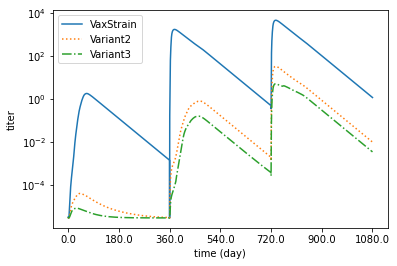

In [12]:
plt.plot(np.concatenate((t1[0][0], t2[0][0], t3[0][0])), label='Strain1 Ep1', color='#1f77b4')
plt.plot(np.concatenate((t1[1][1], t2[1][1], t3[1][1])), label='Strain2 Ep2, color='#ff7f0e', linestyle='dotted')
plt.plot(np.concatenate((t1[2][2], t2[2][2], t3[2][2])), label='Strain3 Ep3', color='#2ca02c', linestyle='dashdot')

plt.semilogy()
tix = np.array([0., 720., 1440., 2160., 2880., 3600., 4320.])
plt.xticks(tix, tix/4)
plt.xlabel('time (day)')
plt.ylabel('titer')

legend_elements = [Line2D([0], [0], color='#1f77b4', label='VaxStrain'),
                   Line2D([0], [0], color='#ff7f0e', linestyle='dotted', label='Strain 2'),
                   Line2D([0], [0], color='#2ca02c', linestyle='dashdot', label='Strain 3'),
                  ]

plt.legend(handles=legend_elements)
# plt.savefig('fig/v1_6_titer_vax1-3.png', bbox_inches = 'tight', dpi=300)

In [14]:
def Ag_conc(results, n_sim):
    '''
    Summary: Returns the Ag concentration, averaged over n_sim simulations
    Input:
        results - results from one immmunization
        n_sim - number of simulations in results
    Output: all_Ag - 4 x N array, N=(tmax*4+1)
        Dim 1: soluble, IC-FDC targeting epitope 1, IC-FDC targeting epitope 2, IC-FDC targeting epitope 3
        Dim 2: time
    '''
    l = results[0]['conc']['concarray'].shape[2]
    all_Ag = [np.ones((1, l)), np.ones((1, l)), np.ones((1, l)), np.ones((1, l))] #soluble, IC-ep1, IC-ep2, IC_ep3
    for i in range(n_sim):
        for strain in range(4):
            Ag = results[i]['conc']['concarray'][0, strain, :]
            all_Ag[strain] = all_Ag[strain] * Ag #for geometric mean
    for strain in range(4):
        all_Ag[strain] = all_Ag[strain] ** (1/n_sim)
        all_Ag[strain] = np.swapaxes(all_Ag[strain], 0, 1)
    return all_Ag

In [15]:
a1 = Ag_conc(all_results1, 10)
a2 = Ag_conc(all_results2, 10)
a3 = Ag_conc(all_results3, 10)
a4 = Ag_conc(all_results4, 10)

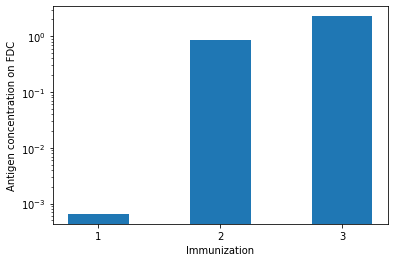

In [18]:
# ignore soluble Ag aX[0]
# maximum concentration during simulation, summed over all epitopes
a1_tot = np.sum((np.max(a1[1]), np.max(a1[2]), np.max(a1[3]))) # Vax 1
a2_tot = np.sum((np.max(a2[1]), np.max(a2[2]), np.max(a2[3]))) # Vax 2
a3_tot = np.sum((np.max(a3[1]), np.max(a3[2]), np.max(a3[3]))) # Vax 3

v = np.array([1, 2, 3])
plt.bar(v, [a1_tot, a2_tot, a3_tot], width=0.5)

plt.semilogy()
plt.xticks(v)
plt.ylabel('Antigen concentration on FDC')
plt.xlabel('Immunization')
# plt.savefig('fig/v1_6_Ag_vax1-3.png', bbox_inches = 'tight', dpi=300)

In [35]:
def mem_binding_aff(results, bins):
    '''
    Summary: Counts the number of GC-produced memory cells in each binding affinity bin
        Results are averaged over 10 simulations
    Input:
        results - results from one immmunization including 10 simulations
        bins - np.array specifiying affinity bins
    Output:
        dom_counts - distribution of memory cells targeting dominant epitope (epitope 1)
        sub1_counts - distribution of memory cells targeting first subdominant epitope (epitope 2)
        sub2_counts - distribution of memory cells targeting second subdominant epitope (epitope 3)
    '''
    dom_counts = np.zeros(bins[:-1].shape)
    sub1_counts = np.zeros(bins[:-1].shape)
    sub2_counts = np.zeros(bins[:-1].shape)
    for i in range(0, 10):
        finalmem = alignLeft(flatten1D(results[i]['output']['finalmem']), 1)
        dom = finalmem[1,:]==1
        sub1 = finalmem[1,:]==2
        sub2 = finalmem[1,:]==3
        WT_aff = finalmem[2,:]
        WT_dom, _ = np.histogram(dom*WT_aff, bins)
        WT_sub1, _ = np.histogram(sub1*WT_aff, bins)
        WT_sub2, _ = np.histogram(sub2*WT_aff, bins)
        dom_counts = dom_counts + WT_dom
        sub1_counts = sub1_counts + WT_sub1
        sub2_counts = sub2_counts + WT_sub2
    dom_counts = dom_counts / 10
    sub1_counts = sub1_counts / 10
    sub2_counts = sub2_counts / 10
    return dom_counts, sub1_counts, sub2_counts

In [36]:
b = np.arange(6, 12, 0.5)
mem_binding_v1 = mem_binding_aff(all_results1, b)
mem_binding_v2 = mem_binding_aff(all_results2, b)
mem_binding_v3 = mem_binding_aff(all_results3, b)
mem_binding_v4 = mem_binding_aff(all_results4, b)

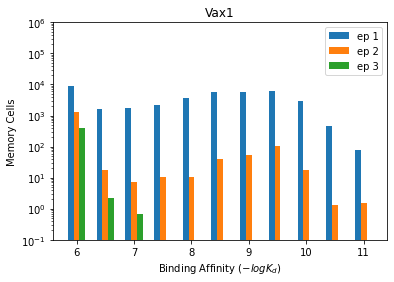

In [41]:
b = np.arange(6, 12, 0.5)
plt.bar(b[:-1]-0.1, mem_binding_v1[0], width=0.1, align='center', label = 'ep 1')
plt.bar(b[:-1], mem_binding_v1[1], width=0.1, align='center', label = 'ep 2')
plt.bar(b[:-1]+0.1, mem_binding_v1[2], width=0.1, align='center', label = 'ep 3')
plt.semilogy()

ytix=[np.array([1.e-1, 1.e+0, 1.e+1, 1.e+2, 1.e+3, 1.e+4, 1.e+5, 1.e+6]), \
        [Text(0, 0.1, '$\\mathdefault{10^{-1}}$'), Text(0, 1.0, '$\\mathdefault{10^{0}}$'), Text(0, 10.0, '$\\mathdefault{10^{1}}$'), Text(0, 100.0, '$\\mathdefault{10^{2}}$'), Text(0, 1000.0, '$\\mathdefault{10^{3}}$'), Text(0, 10000.0, '$\\mathdefault{10^{4}}$'), Text(0, 100000.0, '$\\mathdefault{10^{5}}$'), Text(0, 100000.0, '$\\mathdefault{10^{6}}$')]]
plt.yticks(ytix[0], ytix[1])

plt.xlabel('Binding Affinity ($-logK_d$)')
plt.ylabel('Memory Cells')
plt.title('Vax1')
plt.legend()
# plt.savefig('fig/v1_6_mem_binding_vax1.png', bbox_inches = 'tight', dpi=300)

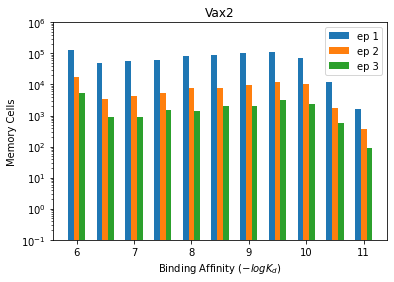

In [43]:
plt.bar(b[:-1]-0.1, mem_binding_v2[0], width=0.1, align='center', label='ep 1')
plt.bar(b[:-1], mem_binding_v2[1], width=0.1, align='center', label='ep 2')
plt.bar(b[:-1]+0.1, mem_binding_v2[2], width=0.1, align='center', label='ep 3')
plt.semilogy()

ytix=[np.array([1.e-1, 1.e+0, 1.e+1, 1.e+2, 1.e+3, 1.e+4, 1.e+5, 1.e+6]), \
        [Text(0, 0.1, '$\\mathdefault{10^{-1}}$'), Text(0, 1.0, '$\\mathdefault{10^{0}}$'), Text(0, 10.0, '$\\mathdefault{10^{1}}$'), Text(0, 100.0, '$\\mathdefault{10^{2}}$'), Text(0, 1000.0, '$\\mathdefault{10^{3}}$'), Text(0, 10000.0, '$\\mathdefault{10^{4}}$'), Text(0, 100000.0, '$\\mathdefault{10^{5}}$'), Text(0, 100000.0, '$\\mathdefault{10^{6}}$')]]
plt.yticks(ytix[0], ytix[1])

plt.xlabel('Binding Affinity ($-logK_d$)')
plt.ylabel('Memory Cells')
plt.title('Vax2')
plt.legend()
# plt.savefig('fig/v1_6_mem_binding_vax2.png', bbox_inches = 'tight', dpi=300)

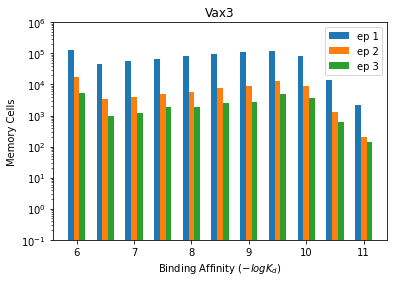

In [44]:
plt.bar(b[:-1]-0.1, mem_binding_v3[0], width=0.1, align='center', label='ep 1')
plt.bar(b[:-1], mem_binding_v3[1], width=0.1, align='center', label='ep 2')
plt.bar(b[:-1]+0.1, mem_binding_v3[2], width=0.1, align='center', label='ep 3')
plt.semilogy()

ytix=[np.array([1.e-1, 1.e+0, 1.e+1, 1.e+2, 1.e+3, 1.e+4, 1.e+5, 1.e+6]), \
        [Text(0, 0.1, '$\\mathdefault{10^{-1}}$'), Text(0, 1.0, '$\\mathdefault{10^{0}}$'), Text(0, 10.0, '$\\mathdefault{10^{1}}$'), Text(0, 100.0, '$\\mathdefault{10^{2}}$'), Text(0, 1000.0, '$\\mathdefault{10^{3}}$'), Text(0, 10000.0, '$\\mathdefault{10^{4}}$'), Text(0, 100000.0, '$\\mathdefault{10^{5}}$'), Text(0, 100000.0, '$\\mathdefault{10^{6}}$')]]
plt.yticks(ytix[0], ytix[1])

plt.xlabel('Binding Affinity ($-logK_d$)')
plt.ylabel('Memory Cells')
plt.title('Vax3')
plt.legend()
# plt.savefig('fig/v1_6_mem_binding_vax3.png', bbox_inches = 'tight', dpi=300)

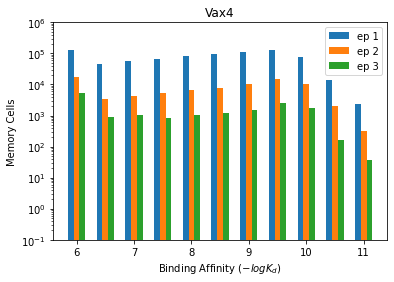

In [45]:
plt.bar(b[:-1]-0.1, mem_binding_v4[0], width=0.1, align='center', label='ep 1')
plt.bar(b[:-1], mem_binding_v4[1], width=0.1, align='center', label='ep 2')
plt.bar(b[:-1]+0.1, mem_binding_v4[2], width=0.1, align='center', label='ep 3')
plt.semilogy()

ytix=[np.array([1.e-1, 1.e+0, 1.e+1, 1.e+2, 1.e+3, 1.e+4, 1.e+5, 1.e+6]), \
        [Text(0, 0.1, '$\\mathdefault{10^{-1}}$'), Text(0, 1.0, '$\\mathdefault{10^{0}}$'), Text(0, 10.0, '$\\mathdefault{10^{1}}$'), Text(0, 100.0, '$\\mathdefault{10^{2}}$'), Text(0, 1000.0, '$\\mathdefault{10^{3}}$'), Text(0, 10000.0, '$\\mathdefault{10^{4}}$'), Text(0, 100000.0, '$\\mathdefault{10^{5}}$'), Text(0, 100000.0, '$\\mathdefault{10^{6}}$')]]
plt.yticks(ytix[0], ytix[1])

plt.xlabel('Binding Affinity ($-logK_d$)')
plt.ylabel('Memory Cells')
plt.title('Vax4')
plt.legend()
# plt.savefig('fig/v1_6_mem_binding_vax4.png', bbox_inches = 'tight', dpi=300)